In [2]:
options(repr.plot.width  = 10, plot.height = 3)
options(jupyter.plot_mimetypes = "image/svg+xml");
library(tidyverse)
library(lubridate)
library(modelr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



# Lecture 20
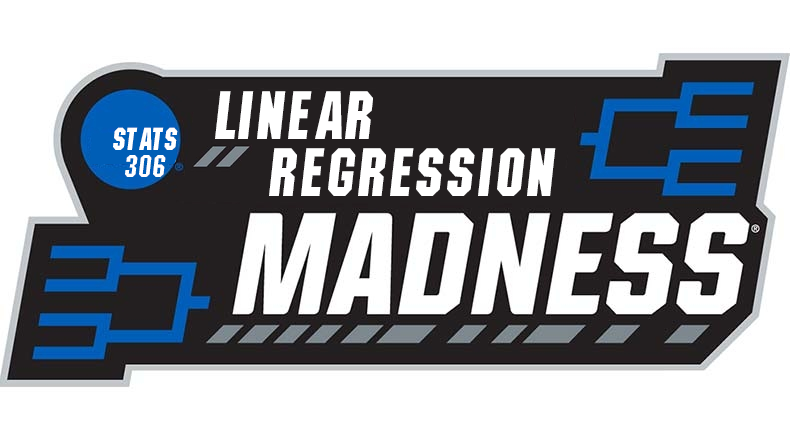

## NCAA data
The files in `data/` ([source](https://github.com/brendanlong/ncaa-predict)) represent 15 years of NCAA basketball data (players/schools/games):

In [3]:
dir("data/")

 [1] "ncaa_games_2002.csv.gz"   "ncaa_games_2003.csv.gz"  
 [3] "ncaa_games_2004.csv.gz"   "ncaa_games_2005.csv.gz"  
 [5] "ncaa_games_2006.csv.gz"   "ncaa_games_2007.csv.gz"  
 [7] "ncaa_games_2008.csv.gz"   "ncaa_games_2009.csv.gz"  
 [9] "ncaa_games_2010.csv.gz"   "ncaa_games_2011.csv.gz"  
[11] "ncaa_games_2012.csv.gz"   "ncaa_games_2013.csv.gz"  
[13] "ncaa_games_2014.csv.gz"   "ncaa_games_2015.csv.gz"  
[15] "ncaa_games_2016.csv.gz"   "ncaa_games_2017.csv.gz"  
[17] "ncaa_players_2002.csv.gz" "ncaa_players_2003.csv.gz"
[19] "ncaa_players_2004.csv.gz" "ncaa_players_2005.csv.gz"
[21] "ncaa_players_2006.csv.gz" "ncaa_players_2007.csv.gz"
[23] "ncaa_players_2008.csv.gz" "ncaa_players_2009.csv.gz"
[25] "ncaa_players_2010.csv.gz" "ncaa_players_2011.csv.gz"
[27] "ncaa_players_2012.csv.gz" "ncaa_players_2013.csv.gz"
[29] "ncaa_players_2014.csv.gz" "ncaa_players_2015.csv.gz"
[31] "ncaa_players_2016.csv.gz" "ncaa_players_2017.csv.gz"
[33] "ncaa_schools.csv.gz"     

In [4]:
df = tibble(csv_files = list.files(path = "data/", pattern = '\\.csv.gz$', full.names = TRUE)) %>% print

# A tibble: 33 x 1
   csv_files                   
   <chr>                       
 1 data//ncaa_games_2002.csv.gz
 2 data//ncaa_games_2003.csv.gz
 3 data//ncaa_games_2004.csv.gz
 4 data//ncaa_games_2005.csv.gz
 5 data//ncaa_games_2006.csv.gz
 6 data//ncaa_games_2007.csv.gz
 7 data//ncaa_games_2008.csv.gz
 8 data//ncaa_games_2009.csv.gz
 9 data//ncaa_games_2010.csv.gz
10 data//ncaa_games_2011.csv.gz
# ... with 23 more rows


Now we are going to see something new: creating and storing a new data frame inside each row of the tibble.

In [5]:
df = df %>% mutate(data = map(csv_files, ~ read_csv(.)))

Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_integer(),
  opponent_score = col_integer(),
  location = col_character(),
  neutral_site_location = col_character(),
  game_length = col_character(),
  attendence = col_integer(),
  opponent_id = col_integer(),
  year = col_integer(),
  school_id = col_integer()
)
Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_integer(),
  opponent_score = col_integer(),
  location = col_character(),
  neutral_site_location = col_character(),
  game_length = col_character(),
  attendence = col_integer(),
  opponent_id = col_integer(),
  year = col_integer(),
  school_id = col_integer()
)
Parsed with column specification:
cols(
  opponent_name = col_character(),
  game_date = col_character(),
  score = col_integer(),
  opponent_score = col_integer(),
  location = col_character(),
  neutral_site_location = col_cha

See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  player_name = col_character(),
  class = col_character(),
  season = col_character(),
  position = col_character(),
  fg_percent = col_double(),
  `3pt_percent` = col_double(),
  freethrows_percent = col_double(),
  rebounds_avg = col_double(),
  assists_avg = col_double(),
  blocks_avg = col_double(),
  steals_avg = col_double(),
  points_avg = col_double(),
  turnovers = col_character(),
  dd = col_character(),
  td = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  player_name = col_character(),
  class = col_character(),
  season = col_character(),
  position = col_character(),
  fg_percent = col_double(),
  `3pt_percent` = col_double(),
  freethrows_percent = col_double(),
  rebounds_avg = col_double(),
  assists_avg = col_double(),
  blocks_avg = col_double(),
  steals_avg = col_dou

In [6]:
print(df)

# A tibble: 33 x 2
   csv_files                    data                  
   <chr>                        <list>                
 1 data//ncaa_games_2002.csv.gz <tibble [27,708 × 11]>
 2 data//ncaa_games_2003.csv.gz <tibble [27,253 × 11]>
 3 data//ncaa_games_2004.csv.gz <tibble [27,549 × 11]>
 4 data//ncaa_games_2005.csv.gz <tibble [28,181 × 11]>
 5 data//ncaa_games_2006.csv.gz <tibble [28,184 × 11]>
 6 data//ncaa_games_2007.csv.gz <tibble [31,579 × 11]>
 7 data//ncaa_games_2008.csv.gz <tibble [30,266 × 11]>
 8 data//ncaa_games_2009.csv.gz <tibble [31,315 × 11]>
 9 data//ncaa_games_2010.csv.gz <tibble [30,930 × 11]>
10 data//ncaa_games_2011.csv.gz <tibble [29,840 × 11]>
# ... with 23 more rows


The `df$data` column contains entries each of which is the result of calling `read_csv` on the corresponding entry in `csv_files.` Since tibbles are lists, the data type of this column reads `<list>`.

In [7]:
df$data[[1]] %>% print

# A tibble: 27,708 x 11
   opponent_name   game_… score oppo… loca… neut… game… atte… oppo…  year scho…
   <chr>           <chr>  <int> <int> <chr> <chr> <chr> <int> <int> <int> <int>
 1 Sul Ross St.    11/16…    93    59 Home  <NA>  <NA>   2041  1390  2002 26172
 2 Texas St.       11/25…    89    99 Home  <NA>  <NA>   1493   670  2002 26172
 3 Loyola Chicago  11/29…    66    86 Away  <NA>  <NA>   1128   371  2002 26172
 4 Illinois        12/01…    56    80 Away  <NA>  <NA>  16500   301  2002 26172
 5 Texas           12/05…    64    89 Away  <NA>  <NA>   6099   703  2002 26172
 6 UTEP            12/08…    56    82 Away  <NA>  <NA>   6203   704  2002 26172
 7 Lamar           12/15…    67    69 Home  <NA>  <NA>   1342   346  2002 26172
 8 San Francisco   12/18…    80    75 Home  <NA>  <NA>   1360   629  2002 26172
 9 Denver          12/21…    81    79 Home  <NA>  <NA>   1415   183  2002 26172
10 Wayland Baptist 12/28…    92    83 Home  <NA>  <NA>   2096    NA  2002 26172
# ... with 27,69

There are three types of data represented in `df`: games, players and schools:

In [8]:
df$csv_files

 [1] "data//ncaa_games_2002.csv.gz"   "data//ncaa_games_2003.csv.gz"  
 [3] "data//ncaa_games_2004.csv.gz"   "data//ncaa_games_2005.csv.gz"  
 [5] "data//ncaa_games_2006.csv.gz"   "data//ncaa_games_2007.csv.gz"  
 [7] "data//ncaa_games_2008.csv.gz"   "data//ncaa_games_2009.csv.gz"  
 [9] "data//ncaa_games_2010.csv.gz"   "data//ncaa_games_2011.csv.gz"  
[11] "data//ncaa_games_2012.csv.gz"   "data//ncaa_games_2013.csv.gz"  
[13] "data//ncaa_games_2014.csv.gz"   "data//ncaa_games_2015.csv.gz"  
[15] "data//ncaa_games_2016.csv.gz"   "data//ncaa_games_2017.csv.gz"  
[17] "data//ncaa_players_2002.csv.gz" "data//ncaa_players_2003.csv.gz"
[19] "data//ncaa_players_2004.csv.gz" "data//ncaa_players_2005.csv.gz"
[21] "data//ncaa_players_2006.csv.gz" "data//ncaa_players_2007.csv.gz"
[23] "data//ncaa_players_2008.csv.gz" "data//ncaa_players_2009.csv.gz"
[25] "data//ncaa_players_2010.csv.gz" "data//ncaa_players_2011.csv.gz"
[27] "data//ncaa_players_2012.csv.gz" "data//ncaa_players_2013.csv.gz"
[29] "

We will first combine each of the relevant data types into large tables:

In [9]:
df$dtype = str_match(df$csv_files, "ncaa_([^_.]+)")[,2]
print(df)

# A tibble: 33 x 3
   csv_files                    data                   dtype
   <chr>                        <list>                 <chr>
 1 data//ncaa_games_2002.csv.gz <tibble [27,708 × 11]> games
 2 data//ncaa_games_2003.csv.gz <tibble [27,253 × 11]> games
 3 data//ncaa_games_2004.csv.gz <tibble [27,549 × 11]> games
 4 data//ncaa_games_2005.csv.gz <tibble [28,181 × 11]> games
 5 data//ncaa_games_2006.csv.gz <tibble [28,184 × 11]> games
 6 data//ncaa_games_2007.csv.gz <tibble [31,579 × 11]> games
 7 data//ncaa_games_2008.csv.gz <tibble [30,266 × 11]> games
 8 data//ncaa_games_2009.csv.gz <tibble [31,315 × 11]> games
 9 data//ncaa_games_2010.csv.gz <tibble [30,930 × 11]> games
10 data//ncaa_games_2011.csv.gz <tibble [29,840 × 11]> games
# ... with 23 more rows


To make the data frames merge correctly, we will coerce a few columns that are missing for some of the years.

In [10]:
for (i in 1:nrow(df)) {
    if (df$dtype[[i]] == "players") {
        df$data[[i]] = mutate_at(df$data[[i]], c("turnovers", "dd", "td"), as.integer)
    }
}

In [11]:
df = df %>% group_by(dtype) %>% do(data=bind_rows(.$data))
games = df[[1, 2]]
games$game_date = mdy(games$game_date)
schools = df[[3, 2]] %>% print

# A tibble: 1,335 x 2
   school_id school_name       
       <int> <chr>             
 1     26172 A&M-Corpus Christi
 2         2 Abilene Christian 
 3     30123 Academy of Art    
 4       929 Adams St.         
 5    506445 Adelbert          
 6         3 Adelphi           
 7         4 Adrian            
 8     11324 Agnes Scott       
 9       721 Air Force         
10         5 Akron             
# ... with 1,325 more rows


How has Michigan basketball done over the past 15 years?

Joining, by = "school_id"
`geom_smooth()` using method = 'loess'


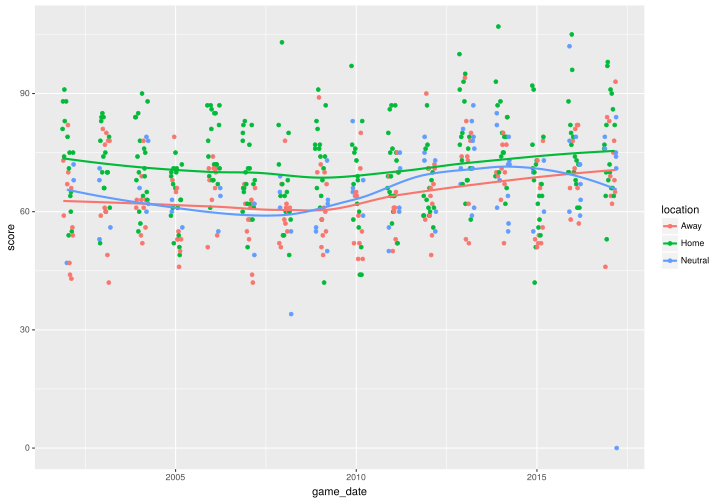

In [12]:
games %>% left_join(schools)  %>% filter(school_name == "Michigan") %>% 
    ggplot(aes(x=game_date, y=score, color=location)) + 
    geom_point() + geom_smooth(se=F)

## Ranking the schools
First we will simply rank the schools by their margins:

In [13]:
games %>% mutate(margin = score - opponent_score) %>% group_by(school_id) %>% 
          summarize(m = mean(margin), n = n()) %>% inner_join(schools) %>% top_n(25, m) %>% 
          arrange(desc(m))

Joining, by = "school_id"


   school_id m         n   school_name         
1   1438     14.496016 502 West Liberty        
2     24     14.093023 473 Amherst             
3    807     13.769388 490 Wooster             
4    328     13.224348 575 Kansas              
5    260     12.823204 543 Gonzaga             
6    193     12.807356 571 Duke                
7    661     12.282258 496 Southern Ind.       
8   1454     12.256696 448 Whitworth           
9    802     12.087794 467 Wis.-Stevens Point  
10  1079     12.072874 494 Findlay             
11   413     11.840777 515 MSU Denver          
12  1395     11.775591 508 Tarleton St.        
13   789     11.257143 455 Williams            
14   333     11.196281 484 Ky. Wesleyan        
15   367     11.121864 558 Louisville          
16   620     10.889130 460 St. Thomas (MN)     
17   235     10.836879 564 Florida             
18   334     10.734622 569 Kentucky            
19   286     10.458248 491 Hope                
20   134     10.246411 418 Chapman      

The highest ranking schools include several of the top D1 programs as well as some smaller schools. We don't have the NCAA division recorded in these data, but can use attendance to pick out the large D1 schools.

In [30]:
top_schools = games %>% mutate(margin = score - opponent_score) %>% group_by(school_id) %>% 
                        summarize(m = sum(attendence)) %>% inner_join(schools) %>% 
                        top_n(300, m) %>% arrange(desc(m)) %>% print

Joining, by = "school_id"


# A tibble: 300 x 3
   school_id        m school_name   
       <int>    <int> <chr>         
 1       334 11177012 Kentucky      
 2       688 10350982 Syracuse      
 3       457  9686651 North Carolina
 4       367  9628657 Louisville    
 5       328  9043852 Kansas        
 6       796  8510709 Wisconsin     
 7       416  8466698 Michigan St.  
 8       518  8278421 Ohio St.      
 9       306  7946485 Indiana       
10       301  7909691 Illinois      
# ... with 290 more rows


In [31]:
games_top300 = games %>% semi_join(top_schools) %>% print

Joining, by = "school_id"


# A tibble: 152,269 x 11
   oppone… game_date  score oppon… locat… neutra… game… atte… oppo…  year scho…
   <chr>   <date>     <int>  <int> <chr>  <chr>   <chr> <int> <int> <int> <int>
 1 Sul Ro… 2001-11-16    93     59 Home   <NA>    <NA>   2041  1390  2002 26172
 2 Texas … 2001-11-25    89     99 Home   <NA>    <NA>   1493   670  2002 26172
 3 Loyola… 2001-11-29    66     86 Away   <NA>    <NA>   1128   371  2002 26172
 4 Illino… 2001-12-01    56     80 Away   <NA>    <NA>  16500   301  2002 26172
 5 Texas   2001-12-05    64     89 Away   <NA>    <NA>   6099   703  2002 26172
 6 UTEP    2001-12-08    56     82 Away   <NA>    <NA>   6203   704  2002 26172
 7 Lamar   2001-12-15    67     69 Home   <NA>    <NA>   1342   346  2002 26172
 8 San Fr… 2001-12-18    80     75 Home   <NA>    <NA>   1360   629  2002 26172
 9 Denver  2001-12-21    81     79 Home   <NA>    <NA>   1415   183  2002 26172
10 Waylan… 2001-12-28    92     83 Home   <NA>    <NA>   2096    NA  2002 26172
# ... with 152,

Joining, by = "school_id"
Joining, by = "school_id"


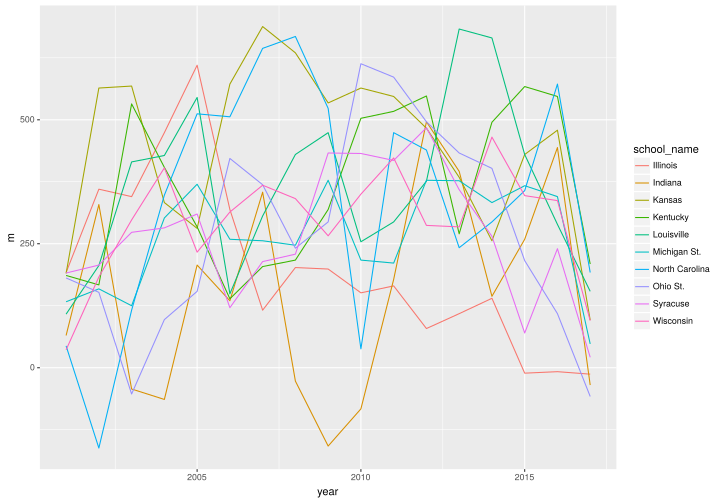

In [32]:
games %>% semi_join(top_schools[1:10,]) %>% mutate(margin = score - opponent_score, 
                                            year = year(game_date)) %>% 
          group_by(year, school_id) %>% 
          summarize(m = sum(margin)) %>% inner_join(schools) %>% 
          ggplot(aes(x = year, y = m, colour = school_name)) +
          geom_line()

## Ranking the teams: logistic regression MCMC
We will use a model called [logistic regression MCMC](https://pdfs.semanticscholar.org/bb21/8ea8e16cc43afb7f50eefc0bea4b0fd35ff1.pdf) to build rankings for the NCAA teams. The basic model is as follows:
- We imagine that there is an imaginary person whose job it is to vote on the best team. 
- The voter picks a random team as the best to begin with, and then iterates the following procedure: 
    - Given that the voter currently believes that team $A$ is the best, she picks a random game that team $A$ played versus some team $B$. 
    - With probability $p$, the voter decides that the winner of $A$ vs. $B$ is the new best team, and with probability $(1-p)$ the voter decides that the *loser* is the new best team.

Suppose team $i$ played $N_i$ games in total. Let $w_{ij},l_{ij}$ be the number of games that $i$ won/lost against team $j$. The probability that our voter goes from thinking that $i$ is the best team, to thinking that $j$ is the best team, is 

$$t_{ij} =\frac{1}{N_i}[w_{ij}(1-p) + l_{ij}(p)].$$

A moment's thought suggests that the probability $p$ should not necessarily be fixed. Indeed, it should be high if team $A$ was "clearly better" than team $B$, whereas if $A$ just "barely beat" team $B$ then it should be close to 1/2.

In this model the probability $p$ will be a function of the *point spread* between teams $A$ and $B$. Specifically, $p$ is the probability that a team that outscores its opponent by $x$ points at home is better than its opponent. This way, very small point spreads can correspond to $p \approx 1/2$ -- it's a tossup which team is better in this scenario.

## Logistic regression model
In order to implement this model, we need a way to estimate 

$$\mathbb{P}(\text{Team A is a better team than B}\mid \text{Team A beat Team B by $x$ points at home}).$$

To study this question we'll first look at a related question which is easier to estimate:

“Given that Team A beat Team B by x points on A’s home court, what is the
probability that A beat B on B’s home court?

This is not quite the same as $A$ beating $B$ on a *neutral* court as in March madness. In fact, it should be harder. Below we will discuss how to calculate the neutral court effect.

We will estimate this using *logistic regression*, which is an extension of linear regression to the case where the outcome variable is binary instead of continuous.
To fit this model, we'll create a dataset of pairs of games. Most conference teams play each other twice per season, once at each campus. We'll look at the outcome of one of the games and use it to predict the outcome of the second game according to the above model.

First we construct a dataset consisting of game pairs (teams which played each other twice during the season.)

In [40]:
game_pairs = games %>% filter(!is.na(school_id), !is.na(opponent_id)) %>% 
                       mutate(id1 = pmin(school_id, opponent_id), 
                              id2 = pmax(school_id, opponent_id)) %>% 
                       distinct(game_date, id1, id2, .keep_all = T)
game_pairs = inner_join(game_pairs, game_pairs, by=c("id1", "id2", "year")) %>% 
             filter(game_date.x != game_date.y) %>% filter(location.x != location.y)

Next, we define our columns for the logistic regression:

In [41]:
game_pairs = game_pairs %>% filter(location.x != location.y, 
                                   location.x != "Neutral", 
                                   location.y != "Neutral") %>%  
                  mutate(home_spread = ifelse(location.x == "Home", 
                                              score.x - opponent_score.x,
                                              score.y - opponent_score.y),
                         away_win = ifelse(location.x == "Home", 
                                           score.y > opponent_score.y,
                                           score.x > opponent_score.x))

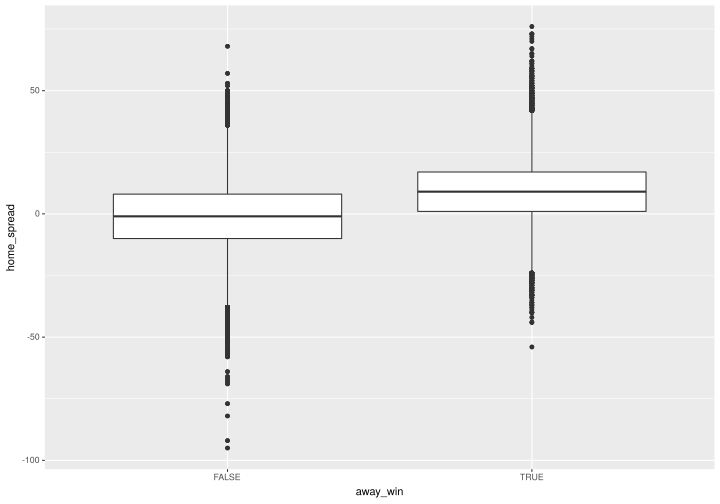

In [42]:
ggplot(game_pairs, aes(x = away_win, y = home_spread)) + geom_boxplot()

Then we run the logistic regression using the `glm()` command. This has the same syntax as the `lm()` command. The key difference is the `family = "binomial"` option, which tells R that our dependent variable is binary instead of continuous.

In [43]:
model = glm(away_win ~ home_spread, data = game_pairs, family = "binomial")
summary(model)


Call:
glm(formula = away_win ~ home_spread, family = "binomial", data = game_pairs)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5451  -0.9952  -0.6689   1.1323   2.6704  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.5554468  0.0062703  -88.58   <2e-16 ***
home_spread  0.0552099  0.0004748  116.29   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 182789  on 134567  degrees of freedom
Residual deviance: 166490  on 134566  degrees of freedom
AIC: 166494

Number of Fisher Scoring iterations: 4


Let's see how well our logistic regression model fits to data:

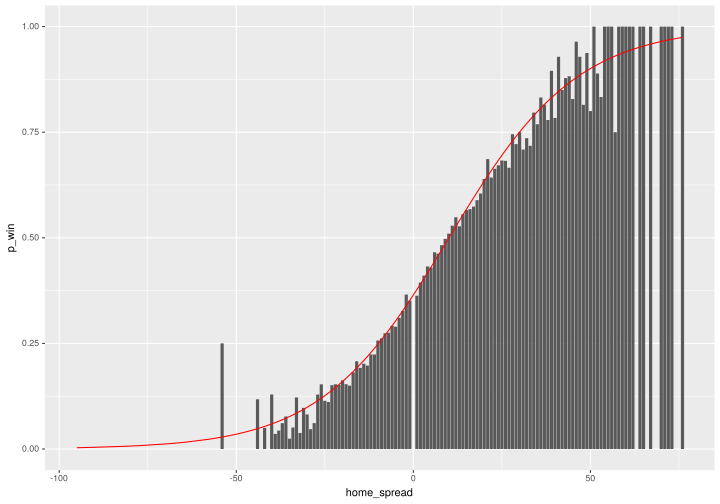

In [44]:
game_pairs %>% group_by(home_spread) %>% summarize(p_win = mean(away_win), sdp = sd(away_win)) %>%
    add_predictions(model) %>% mutate(pred = plogis(pred)) %>% 
    ggplot(aes(x = home_spread)) + 
    geom_col(aes(y = p_win)) + 
    geom_line(aes(y = pred), color = "red")

The home court advantage $h$ is the average point spread bonus given to the home team. We can estimate this by finding the home point spread that leads to 50/50 odds of winning the away game. 

In [45]:
beta = coef(model)
(h = -beta[1] / beta[2])
r_H = function(x) plogis(beta %*% c(1, x + h))

(Intercept) 
   10.06064 

The home team advantage is worth about 5 points.

Finally we construct our voter model. In technical terms this is a Markov chain, and we can calculate its long-run probabilities by building a Markov matrix.

In [120]:
f = function(df) {
    ret = rep(0, k)
    names(ret) = sids
    for (j in seq_along(df$school_id)) {
        row = df[j,]
        t = as.character(df[[j, "opponent_id"]])
        if (row$location == "Home") {
            ret[t] = ret[t] + 1 - r_H(df[[j, "score"]] - df[[j, "opponent_score"]])
        } else {
            ret[t] = ret[t] + r_H(df[[j, "opponent_score"]] - df[[j, "score"]])
        }
    }
    ret / nrow(df)
}

In [122]:
games_nona = games %>% filter(!is.na(opponent_id), !is.na(school_id), location != "Neutral")
sids = as.character(unique(c(games_nona$school_id, games_nona$opponent_id)))
k = length(sids)
M = matrix(0, nrow = k, ncol = k)
rownames(M) = sids
colnames(M) = sids



In [124]:
#for (s in sids) {
#    df = games_nona %>% filter(school_id == s)
#    if (nrow(df) > 0)
#        M[s,] = f(df)
#    M[s, s] = 1. - sum(M[s, ])
#}
#save(M, file = "M.RData")
load("M.RData")
M[1:10, 1:10]

      26172        2          929       3         4           721        
26172 0.4914306475 0.00373781 0.0000000 0.0000000 0.000000000 0.003263067
2     0.0121407261 0.42810189 0.0000000 0.0000000 0.000000000 0.000000000
929   0.0000000000 0.00000000 0.4898049 0.0000000 0.000000000 0.000000000
3     0.0000000000 0.00000000 0.0000000 0.5544908 0.000000000 0.000000000
4     0.0000000000 0.00000000 0.0000000 0.0000000 0.472928030 0.000000000
721   0.0015266403 0.00000000 0.0000000 0.0000000 0.000000000 0.508527130
5     0.0000000000 0.00000000 0.0000000 0.0000000 0.000106806 0.000000000
10    0.0000000000 0.00000000 0.0000000 0.0000000 0.000000000 0.000000000
8     0.0005201934 0.00000000 0.0000000 0.0000000 0.000000000 0.000000000
6     0.0000000000 0.00000000 0.0000000 0.0000000 0.000000000 0.000000000
      5           10          8           6          
26172 0.000000000 0.000000000 0.001889988 0.000000000
2     0.000000000 0.000000000 0.000000000 0.000000000
929   0.000000000 0.0000

In [159]:
# Remove degenerate rows
degen = near(diag(M), 1)
Md = M[!degen, !degen]
library(expm)
p = (Md %^% 2000)[1,]
p = p / sum(p)

In [163]:
tibble(p=p, school_id=as.integer(names(p))) %>% inner_join(schools) %>% arrange(desc(p))

Joining, by = "school_id"


     p            school_id school_name      
1    0.004973881  328       Kansas           
2    0.004855945  193       Duke             
3    0.004360657  457       North Carolina   
4    0.004278211  367       Louisville       
5    0.004202822  334       Kentucky         
6    0.004179964  796       Wisconsin        
7    0.004041282  235       Florida          
8    0.003927163   29       Arizona          
9    0.003922857  518       Ohio St.         
10   0.003878620  545       Pittsburgh       
11   0.003853608  416       Michigan St.     
12   0.003836726  688       Syracuse         
13   0.003682808  703       Texas            
14   0.003619073  739       Villanova        
15   0.003616595  404       Memphis          
16   0.003597346  164       UConn            
17   0.003513297  260       Gonzaga          
18   0.003474083  513       Notre Dame       
19   0.003466045  392       Maryland         
20   0.003295458  559       Purdue           
21   0.003294893  110       UCLA  

Warning message:
“package ‘magick’ was built under R version 3.4.4”Linking to ImageMagick 6.9.9.39
Enabled features: cairo, fontconfig, freetype, lcms, pango, rsvg, webp
Disabled features: fftw, ghostscript, x11


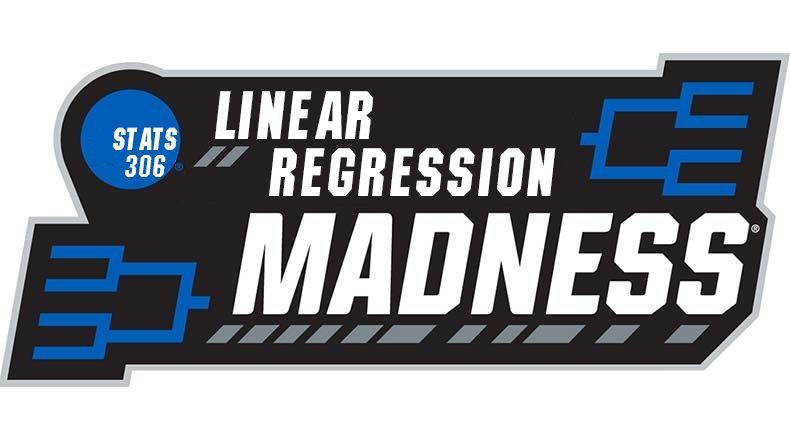

  format width height colorspace matte filesize density
1    PNG   790    440       sRGB FALSE   155510   28x28


In [19]:
library(magick)
madness = image_read('madness.png')
print(madness)

In [ ]:
madness_mean = image_blur(madness, 10)
madness_mean_sq = image_composite(img_mean, img_mean, operator="multiply")

In [ ]:
madness_sq = image_composite(madness, madness, operator = "multiply")
madness_dev = image_composite(madness_sq, madness_mean_sq, operator="subtract")
image_blur(madness_dev, 10) %>% image_channel("blue")